<a href="https://colab.research.google.com/github/saarangmahun/comp215/blob/main/labs/lab09_fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Name: Saarang Singh Mahun

Date: 03-20-2025

# Lab 9: A CA model of Natural Disturbance
In [1990](https://doi.org/10.1016/0375-9601(90)90451-S) Bak, Chen and Tang proposed a cellular automaton that is an abstract model of a forest fire. Each cell is in one of three states: empty, occupied by forest, or on fire.

3 ecological processes are modelled: forest regeneration, fire ignition, and fire spread

  * empty cells "regenerate" forest at a fixed rate, $p$
  * forest fires ignite with a regular but small frequency, $f$
  * forested cells catch fire when their neighbours are burning, and burn out in one time step.

In this lab, you will develop 2D CA class that implements this model.

In [ ]:
%matplotlib inline

import time
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

### Helpers
Some useful, re-usable bits of code developed in previous notebooks...

In [ ]:
# Qualitative colour map with value 0 set to white
tab20_mod = matplotlib.colormaps['tab20']
tab20_mod.colors = ((1,1,1,1), *tab20_mod.colors[1:])

def plot_2d_array(array, axes=None, title='', cmap=tab20_mod, **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

In [1]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

## Ex. 7.1: Define the Cellular Automata
This 2D CA will be similar to those we've seen before.

1. Define the kernel (correlation matrix) to compute the spread of fire
    * what do we need to know about a cell's neighbourhood to know if it should catch fire?
    
    #Ans: For a cell to catch fire, we need to know if any of its eight neighbors are burning.
    
    * how can we encode that using a dot product with a 3 x 3 correlation matrix?
    
    #Ans: We can create a 3×3 kernel that has a 1 in every neighbor position and a 0 in the center. When we take a dot product (or use a 2D correlation) with a binary map of burning cells (where burning cells are 1, others 0), the result tells should tell us how many burning neighbors there are. If the result is 1 or more, the cell should catch fire.

2. The step function will be more complex because it must implement the **4 rules**:

  *  An empty cell becomes occupied with probability $p$.
  *  An occupied cell spontaneously burns, with probability $f$, even if none of its neighbors is on fire.
  *  An occupied cell that is on fire becomes an empty cell in the next time step.
  *  A occupied catches fire if any of its neighbors is on fire.

Typical values for the parameters are $p=0.01$ and $f=0.001$

In [2]:
class ForestFire:
    """ 2D Cellular Automaton that simulates a fire-dominated landscape """

    # Define names for the 3 possible cell states
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 5

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # TODO: define a sensible correlation kernel to detect cardinal neighbourhood on fire
    kernel = np.array([[0, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]])


    def __init__(self, n, p=0.01, f=0.001, q=0.5):
        """Initializes the model.

        n: number of rows
        p: probability an empty cells becomes "forested" (occupied)
        f: probability of spontaneous file (e.g., 1/fire ignition interval)
        q: initial forest density (probability cell is "forested" in initial state)
        """
        self.p = p
        self.f = f
        # initialize landscape with approx. q proportion of cells OCCUPIED
        self.state = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])


    def step(self):
        """Executes one time step, applying the CA rules to regenerate and burn forest."""
        # TODO: define the rules for the CA.  This is a significant challenge b/c there are 4 rules and they must act independently!
        # Tips: develop 1 rule at a time, in the order above, leaving fire spread (correlation) till last.
        #       Compute each rule in 2 steps: (1) identify which cells the rule applies to; (2) update those cells.
        #       Use the next code block, below, to test as you go.


    def num_occupied(self):
        """ return the number of cells occupied by forest """
        return 0  # TODO: count the number of forested cells.


    def pct_occupied(self):
        """ return the proportion of cells occupied by forest """
        return self.num_occupied() / self.state.size


    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.gca()
        title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2d_array(self.state, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))

NameError: name 'matplotlib' is not defined

In [54]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import correlate2d
from pprint import pprint

# Use a qualitative colormap
tab20_mod = matplotlib.colormaps['tab20']
tab20_mod.colors = ((1, 1, 1, 1), *tab20_mod.colors[1:])

def plot_2d_array(array, axes=None, title='', cmap=tab20_mod, **options):
    axes = axes or plt.gca()
    axes.set_title(title)
    axes.tick_params(axis='both', which='both', bottom=False, top=False,
                     left=False, right=False, labelbottom=False,
                     labeltop=False, labelleft=False, labelright=False)
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

class ForestFire:
    """2D Cellular Automaton modeling forest fire dynamics."""

    # Define states
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 5

    # Define a colour map for display.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)    # brown: empty
    cmap[OCCUPIED] = (0, 1, 0)     # green: forest
    cmap[FIRE] = (1, 0, 0)         # red: fire
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # Kernel to check cardinal neighbors (up, down, left, right)
    kernel = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ])

    def __init__(self, n, p=0.01, f=0.001, q=0.5):
        """
        n: number of rows (and columns)
        p: probability an empty cell grows forest
        f: probability an occupied cell ignites spontaneously
        q: initial forest density (chance cell is forested)
        """
        self.p = p
        self.f = f
        # Initialize with approx. q fraction of OCCUPIED cells.
        self.state = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n),
                                      p=[q, 1 - q])

    def step(self):
        """Update the CA by applying regeneration, ignition, burning out, and fire spread."""
        old_state = self.state.copy()
        new_state = old_state.copy()

        # Rule 1: Empty cell becomes forest with probability p.
        empty_mask = (old_state == self.EMPTY)
        regen = np.random.rand(*old_state.shape)
        new_state[empty_mask & (regen < self.p)] = self.OCCUPIED

        # Rule 2: Occupied cell ignites spontaneously with probability f.
        occupied_mask = (old_state == self.OCCUPIED)
        ignite = np.random.rand(*old_state.shape)
        new_state[occupied_mask & (ignite < self.f)] = self.FIRE

        # Rule 3: Burning cells become empty.
        fire_mask = (old_state == self.FIRE)
        new_state[fire_mask] = self.EMPTY

        # Rule 4: Fire spreads: Occupied cells catch fire if a cardinal neighbor is on fire.
        # Build a binary grid where FIRE is 1.
        fire_grid = (old_state == self.FIRE).astype(np.uint8)
        # Use correlation to count burning neighbors.
        fire_neighbors = correlate2d(fire_grid, self.kernel, mode='same', boundary='wrap')
        spread_mask = (old_state == self.OCCUPIED) & (fire_neighbors > 0)
        new_state[spread_mask] = self.FIRE

        self.state = new_state

    def num_occupied(self):
        """Count forested (occupied) cells."""
        return np.sum(self.state == self.OCCUPIED)

    def pct_occupied(self):
        """Proportion of forested cells."""
        return self.num_occupied() / self.state.size

    def draw(self, axes=None, step=''):
        """Draw the CA using the forest colour map."""
        axes = axes or plt.gca()
        title = f'Time: {step} Occupied: {round(self.pct_occupied()*100, 2)}%'
        plot_2d_array(self.state, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0,
                      vmax=len(self.forest_colour_map.colors))

# Code-a-little Test-a-little:
if __name__ == '__main__':
    # Test with a small 3x3 grid.
    m = ForestFire(3, p=0.459, f=0.2)
    m.state = np.array([
        [0, 1, 0],
        [1, 1, 0],
        [5, 0, 1]
    ], dtype=np.uint8)
    m.step()
    pprint(m.state)


array([[1, 1, 1],
       [5, 1, 1],
       [0, 0, 5]], dtype=uint8)


In [8]:
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d
from pprint import pprint

# Modify the colormap so 0 is a light (brown) colour, etc.
tab20_mod = matplotlib.colormaps['tab20']
tab20_mod.colors = ((1, 1, 1, 1), *tab20_mod.colors[1:])

def plot_2d_array(array, axes=None, title='', cmap=tab20_mod, **options):
    axes = axes or plt.gca()
    axes.set_title(title)
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

class ForestFire:
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 5

    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)    # brown (empty)
    cmap[OCCUPIED] = (0, 1, 0)     # green (forest)
    cmap[FIRE] = (1, 0, 0)         # red (fire)
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # Kernel to check the 4 cardinal neighbors for fire.
    kernel = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ])

    def __init__(self, n, p=0.01, f=0.001, q=0.5):
        self.p = p  # Probability empty becomes forest
        self.f = f  # Probability forest ignites spontaneously
        # Create initial state with approx. q fraction forest, rest empty.
        self.state = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])

    def step(self):
        old_state = self.state.copy()
        new_state = old_state.copy()

        # Use separate random matrices for regeneration and ignition.
        rand_regen = np.random.rand(*old_state.shape)
        rand_ignite = np.random.rand(*old_state.shape)

        # Rule 1: Empty cell becomes forest with probability p.
        empty_mask = (old_state == self.EMPTY)
        new_state[empty_mask & (rand_regen < self.p)] = self.OCCUPIED

        # Rule 2: Forest cell burns spontaneously with probability f.
        occupied_mask = (old_state == self.OCCUPIED)
        new_state[occupied_mask & (rand_ignite < self.f)] = self.FIRE

        # Rule 3: Burning cell becomes empty.
        fire_mask = (old_state == self.FIRE)
        new_state[fire_mask] = self.EMPTY

        # Rule 4: Forest cell catches fire if any neighbor is burning.
        fire_grid = (old_state == self.FIRE).astype(np.uint8)
        neighbor_fire = correlate2d(fire_grid, self.kernel, mode='same', boundary='wrap')
        new_state[occupied_mask & (neighbor_fire > 0)] = self.FIRE

        self.state = new_state

    def num_occupied(self):
        return np.sum(self.state == self.OCCUPIED)

    def pct_occupied(self):
        return self.num_occupied() / self.state.size

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()
        title = f'Time: {step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2d_array(self.state, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))

# Code-a-little Test-a-little
#if __name__ == '__main__':
    # Use a very small model with high regen and fire chance for testing.
#    m = ForestFire(3, p=0.5, f=0.2)
#    m.state = np.array([
#        [0, 1, 0],
#        [1, 1, 0],
#        [5, 0, 1],
#    ], dtype=np.uint8)
#    m.step()
#   pprint(m.state)


## Ex. 7.2: Animation
Create a simple animation (using Animate2D class provided) so we can visualize and verify the system dynamics.  This can take about 5 minutes to run...

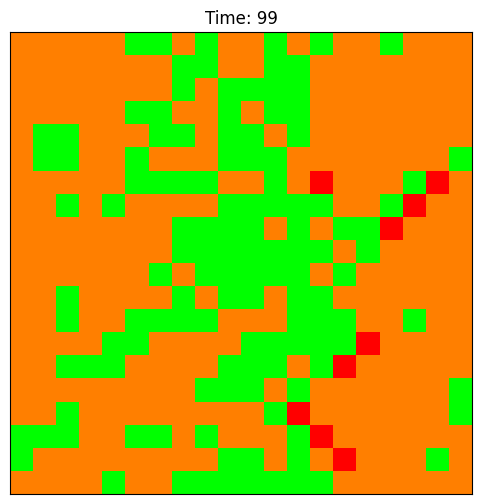

In [55]:
# Ex. 7.2 here
#  Suggestions: use a small grid (e.g., 20x20)  and
#               a short animation (100 frames) with interval=0.3, to slow it down so you can inspect its behaviour
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d
from IPython.display import clear_output

# Configure matplotlib's animation to work in the browser.
matplotlib.rc('animation', html='jshtml')

# -------------------
class Animation2D:
    def __init__(self, model, frames=100, steps_per_frame=1, figsize=(6,6)):
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()
        return anim

    def animate(self, interval=None):
        try:
            for i in range(self.frames):
                clear_output(wait=True)
                self.ax.clear()
                plt.figure(self.fig)
                self.animation_step(i)
                plt.show()
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

# -------------------
class ForestFire:
    # Define cell states.
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 5

    # Define a colour map for display:
    # brown for empty, green for forest, red for fire.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)    # empty: brown
    cmap[OCCUPIED] = (0, 1, 0)     # forest: green
    cmap[FIRE] = (1, 0, 0)         # fire: red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # Kernel to check only the 4 cardinal neighbors.
    kernel = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ])

    def __init__(self, n, p=0.01, f=0.001, q=0.5):
        """
        n: grid size (n x n)
        p: probability an empty cell becomes forest
        f: probability an occupied cell ignites rapidly
        q: initial forest density (chance a cell is forested)
        """
        self.p = p
        self.f = f
        self.state = np.random.choice([self.OCCUPIED, self.EMPTY],
                                      (n, n), p=[q, 1 - q])

    def step(self):
        old_state = self.state.copy()
        new_state = old_state.copy()

        # Generate random numbers for regeneration and spontaneous ignition.
        regen = np.random.rand(*old_state.shape)
        ignite = np.random.rand(*old_state.shape)

        # Rule 1: Empty cell becomes forest with probability p.
        empty_mask = (old_state == self.EMPTY)
        new_state[empty_mask & (regen < self.p)] = self.OCCUPIED

        # Rule 2: Occupied cell ignites spontaneously with probability f.
        occupied_mask = (old_state == self.OCCUPIED)
        new_state[occupied_mask & (ignite < self.f)] = self.FIRE

        # Rule 3: Burning cell becomes empty.
        fire_mask = (old_state == self.FIRE)
        new_state[fire_mask] = self.EMPTY

        # Rule 4: Occupied cell catches fire if any neighbor is burning.
        fire_grid = (old_state == self.FIRE).astype(np.uint8)
        fire_neighbors = correlate2d(fire_grid, self.kernel, mode='same', boundary='wrap')
        spread_mask = (old_state == self.OCCUPIED) & (fire_neighbors > 0)
        new_state[spread_mask] = self.FIRE

        self.state = new_state

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()
        title = f'Time: {step}'
        axes.set_title(title)
        axes.tick_params(axis='both', which='both', bottom=False, top=False,
                         left=False, right=False, labelbottom=False,
                         labeltop=False, labelleft=False, labelright=False)
        axes.imshow(self.state, cmap=self.forest_colour_map,
                    vmin=0, vmax=len(self.forest_colour_map.colors),
                    interpolation='nearest', origin='upper')

# -------------------
# Created a 20x20 forest fire model with typical parameters.
fire_model = ForestFire(20, p=0.01, f=0.001, q=0.5)

# Animate the model for 100 frames, slowing it down with an interval of 0.3 seconds.
anim = Animation2D(fire_model, frames=100, steps_per_frame=1, figsize=(6,6))
anim.animate(interval=0.3)



### Question 7.3:
In what ways is this model similar to Diffusion and/or Percolation?
What kinds of behaviours might we predict from this more complex model based on what we learned from the simpler Diffusion and/or Precolation models?
Provide concise (brief, point-form) answers below:

#### Answers:

1) Similarities to Diffusion:

- Fire spreads from one cell to nearby cells, similar to how particles diffuse.
- The slow regrowth of trees is like a gradual mixing process.

2)Similarities to Percolation:

- The fire’s ability to spread depends on how connected the trees are.
- There is a threshold density; if trees are far spread from one another, fire dies out. If they are dense, fire can travel far.

3) Predictions:

- We might see chunks of burning areas and safe zones.
- Small changes in tree placements could cause big changes in fire spread.
- The system may switch suddenly from low activity to large wildfires when the forest is connected enough.